# AutoSteer Project

## detect middle line on a road inside FS22

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import sklearn
import glob
import math

# Canny and HSV

In [ ]:
def roi(img_mask,img, vertices):
    mask = np.zeros_like(img_mask)
    cv2.fillPoly(mask,vertices,255)
    masked = cv2.bitwise_and(img, mask)
    return masked

In [ ]:
def readImg(path):
    
    #img = cv2.imread("./images/img2.png")
    img = cv2.imread(path)
    size = (1280, 720)
    img = cv2.resize(img, size)
    org_img = np.copy(img)
    return org_img

def hsv(hsv_img):
    hsv = cv2.cvtColor(hsv_img, cv2.COLOR_BGR2HSV)
    sensitivity = 70
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    res = cv2.bitwise_and(hsv_img,hsv_img, mask= mask)
    #hsv_img = res
    return res


In [ ]:
def canny_and_roi(img,in_roi,togray=True):
    if togray:
        img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        img_gray = np.copy(img)
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(img_gray,(kernel_size, kernel_size),0)
    #cv2.imshow('image',blur_gray)
    #cv2.waitKey()
    #cv2.destroyAllWindows()
    low_threshold = 120
    high_threshold = 265
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    if in_roi:
    #roi_vertices = vertices = np.array([[0,500],[10,300], [300,200], [500,200], [800,300], [800,500]], np.int32)
        roi_vertices = np.array([[340,700],[340,300], [250,80], [530,80], [880,300], [880,700]], np.int32)
        processed_img = roi(edges, [roi_vertices])
        return processed_img
    else:
        return edges



In [ ]:
def hough(h_img,org_img):
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 50  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40  # minimum number of pixels making up a line
    max_line_gap = 35  # maximum gap in pixels between connectable line segments
    line_image = np.copy(org_img) # * 0  # creating a blank to draw lines on
    size = (1280, 720)
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(h_img, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    line_m = []
    y_max = 800
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,255,0),2)
            m = (y2-y1)/(x2-x1)
            if x2<size[0]/2:
                if m < -6 :
                    line_m += [m]

                #get 
                if y1 < y_max:
                    y_max = y1
                    line_max = (x1,y1)
                if y2 < y_max:
                    y_max = y2
                    line_max = (x2,y2)

    print("point with maximum y value (near bottom of screen): ",line_max)        
    print("all m of lines: ",line_m)
    mean_m = np.mean(line_m)
    print("avergae m of lines: ",mean_m)

    #Geradengleichung y = mx + n
    #n = y-m*x
    n = line_max[1] - mean_m * line_max[0]
    print("average line n: ",n)


    #draw line with average m from bottom point of all lines to edge of screen point
    edge_screen_y = 700
    edge_screen_x = (edge_screen_y - n)/mean_m
    edge_point = (int(edge_screen_x),int(edge_screen_y))

    cv2.circle(line_image,line_max,5,(255,0,255),5)   
    cv2.circle(line_image,edge_point,5,(255,0,255),5)  
    cv2.line(line_image,line_max,edge_point,(255,0,255),2)

    #draw image center
    cv2.circle(line_image,(int(size[0]/2),int(size[1]/2)),5,(255,255,255),5)        


    #draw middle line at center
    middle_screen_y = size[1]/2
    middle_screen_x = (middle_screen_y - n)/mean_m
    middle_point = (int(middle_screen_x),int(middle_screen_y))
    cv2.circle(line_image,middle_point,5,(255,0,255),5)  

    #calc distance between line and center at center height
    print("diff line: ",size[0]/2 - middle_screen_x)



    return line_image, size[0]/2 - middle_screen_x
    #cv2.imshow('image',line_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [ ]:
img = readImg("./images/img5.png")
img1 = hsv(img)
processed_img = canny_and_roi(img1)
processed_img1,diff = hough(processed_img,img)
plt.figure(figsize=(6, 4), dpi=150)
plt_img = cv2.cvtColor(processed_img1,cv2.COLOR_BGR2RGB)
plt.imshow(plt_img)

Problem with other lines detected

In [ ]:
diffs = []
for file in glob.glob("./sequence/1/*.png"):
    print(file)
    img = readImg(file)
    img1 = hsv(img)
    processed_img = canny_and_roi(img1)
    processed_img1,diff = hough(processed_img,img)
    diffs += [diff]
    cv2.imshow('image',processed_img1)
    cv2.waitKey()
cv2.destroyAllWindows()
print(diffs)
#compare current distance between middle point and line middle and the distance in the frame before
#steer accordingly
#at the beginning: set an optimal distance

In [ ]:
plt.figure(figsize=(6, 4), dpi=150)
plt_img = cv2.cvtColor(line_image,cv2.COLOR_BGR2RGB)
plt.imshow(plt_img)

## Detect outer edge of Car/Tractor

In [ ]:
img = cv2.imread("./images/img1.png")
size = (1280, 720)
img = cv2.resize(img, size)
org_img = np.copy(img)
cv2.imshow('image',org_img)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
#size = (1280, 720)
roi_box_size = 150
center = tuple(int(s/2) for s in size)
print(center)
roi_vertices_box = np.array([[center[0]-roi_box_size,center[1]-roi_box_size],
                         [center[0]-roi_box_size,center[1]+roi_box_size],
                         [center[0]+roi_box_size,center[1]+roi_box_size],
                         [center[0]+roi_box_size,center[1]-roi_box_size]], np.int32)
#img = cv2.cvtColor(org_img,cv2.COLOR_BGR2GRAY)
processed_img = roi(img, [roi_vertices_box])

cv2.imshow('image',processed_img)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
low_threshold = 130
high_threshold = 200
def on_low(val):
    global low_threshold
    low_threshold = val
    cv2.setTrackbarPos("low", 'Canny Edge Detection', low_threshold)
def on_high(val):
    global high_threshold
    high_threshold = val
    cv2.setTrackbarPos("high", 'Canny Edge Detection', high_threshold)

In [ ]:
cv2.namedWindow('Canny Edge Detection')
cv2.createTrackbar("low",'Canny Edge Detection',0,255,on_low)
cv2.createTrackbar("high",'Canny Edge Detection',0,255,on_high)
low_threshold = 130
high_threshold = 200
while(1):
    edges = cv2.Canny(processed_img, low_threshold, high_threshold)
    cv2.imshow('Canny Edge Detection',edges)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

In [ ]:
low_threshold = 105
high_threshold = 255
edges = cv2.Canny(processed_img, low_threshold, high_threshold)
cv2.imshow('Canny Edge Detection',edges)
cv2.waitKey()
cv2.destroyAllWindows()

# TEST

https://stackoverflow.com/questions/45531074/how-to-merge-lines-after-houghlinesp

In [ ]:
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)


In [ ]:
# Usage:
img = readImg("images/img3.png")
edges = canny_and_roi(img,True)
#lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)


rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 70  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 45  # minimum number of pixels making up a line
max_line_gap = 75  # maximum gap in pixels between connectable line segments
#line_image = np.copy(org_img) # * 0  # creating a blank to draw lines on
size = (1280, 720)
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines_normal = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
bundler = HoughBundler(min_distance=5,min_angle=0)
lines = bundler.process_lines(lines_normal)
print(lines)
line_image = np.copy(img)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,255,0),4)

for line in lines_normal:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(0,0,0),1)
cv2.imshow('image',line_image)
cv2.waitKey()
cv2.destroyAllWindows()

# 

# Filtering and FindContours

In [3]:
def show_images(images, titles=None):
    fig, ax = plt.subplots(ncols=len(images), figsize=(len(images)*5,5))

    for idx, image in enumerate(images):
        ax[idx].imshow(image, cmap='gray')
        ax[idx].axis(False)
        if(titles != None):
            ax[idx].set_title(titles[idx])
    return

In [79]:
from skimage.filters import try_all_threshold, threshold_yen
from skimage import color,io,exposure

from skimage.morphology import erosion, dilation, opening, closing, diamond


# read image
org_img = io.imread('./images/img5.jpg')
image = np.copy(org_img)
image = color.rgb2gray(image)
#img_hist = exposure.equalize_hist(image)

# Apply all methods and visualize results
#try_all_threshold(image, figsize=(10,8), verbose=False)
thresh = threshold_yen(image, nbins=128)
print(thresh)

# computer binary image
image_bin = image > thresh
#image_bin = image <= thresh


#plt.imshow(image_bin, cmap="gray")

0.77734375


In [80]:
#element = np.array([[0, 1, 0], 
#                    [1, 1, 1], 
#                    [0, 1, 0]])
elements = [np.ones((1,2), dtype=int),
    #np.array([[1, 1, 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]]),
            np.array([[0, 1, 0], 
                      [1, 1, 1], 
                      [0, 1, 0]])
            #np.array([[1,0],[0,1]]),
            #np.array([[0,1],[1,0]])
           #np.array([[1, 1, 1], 
           #           [1, 1, 1]]),
           
           ]
for element in elements:
    print(element)
    image_bin = erosion(image_bin, footprint=element)
print(np.max(image_bin))
print(image_bin.dtype)
#plt.imshow(image_bin)

[[1 1]]
[[0 1 0]
 [1 1 1]
 [0 1 0]]
True
bool


In [81]:
#image_bin = dilation(image_bin, footprint=np.ones((1,100), dtype=int))
#plt.imshow(image_bin)

In [82]:
#roi_vertices = vertices = np.array([[0,500],[10,300], [300,200], [500,200], [800,300], [800,500]], np.int32)
#roi_vertices = np.array([[340,700],[340,300], [250,80], [530,80], [880,300], [880,700]], np.int32)
#cv2.fillPoly(image,roi_vertices,255)
#processed_img = roi(image,image_bin, [roi_vertices])
image = exposure.rescale_intensity(image_bin,in_range=(0,1),out_range='uint8')
contours = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#show_images([image_bin,processed_img])
#print(contours)
#print(contours[0])

In [83]:
#cv2.drawContours(org_img, contours, -1, (0, 255, 0), 3)
image = cv2.drawContours(org_img, contours[0], -1, (0,255,0), 3)
#plt.imshow(image, cmap="gray")

In [84]:
def not_in__middle(x,y,dist,image):
    x_mid = image.shape[1]//2
    y_mid = image.shape[0]//2
    
    #return true if pixel is out of middle area
    #return (x < x_mid - dist or x > x_mid + dist) and (y < y_mid - dist or y > y_mid + dist)
    return (x < x_mid - dist or x > x_mid + dist) and (y < y_mid - y_mid or y > y_mid + dist)

(93, 1)
(93,)
LinearRegression()
(250, 1)
-10.96153846153841 9717.384615384575
[ 1496.23076923  1485.26923077  1474.30769231  1463.34615385
  1452.38461538  1441.42307692  1430.46153846  1419.5
  1408.53846154  1397.57692308  1386.61538462  1375.65384615
  1364.69230769  1353.73076923  1342.76923077  1331.80769231
  1320.84615385  1309.88461538  1298.92307692  1287.96153846
  1277.          1266.03846154  1255.07692308  1244.11538462
  1233.15384615  1222.19230769  1211.23076923  1200.26923077
  1189.30769231  1178.34615385  1167.38461538  1156.42307692
  1145.46153846  1134.5         1123.53846154  1112.57692308
  1101.61538462  1090.65384615  1079.69230769  1068.73076923
  1057.76923077  1046.80769231  1035.84615385  1024.88461538
  1013.92307692  1002.96153846   992.           981.03846154
   970.07692308   959.11538462   948.15384615   937.19230769
   926.23076923   915.26923077   904.30769231   893.34615385
   882.38461538   871.42307692   860.46153846   849.5
   838.53846154   82

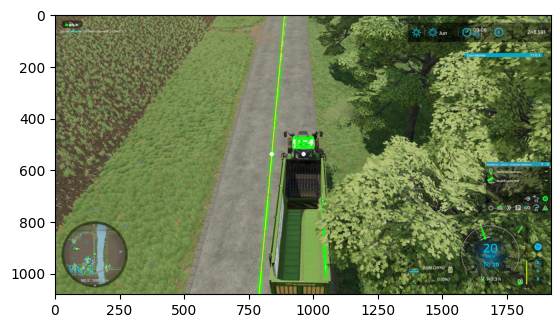

In [87]:
#print(contours[0])
from sklearn.linear_model import LinearRegression
from scipy import stats
x_arr = []
y_arr = []
for c in contours[0]:
    #print(len(c))
    if len(c) > 12:
        #print(c)
        #print(c[0][0][0],c[0][0][1])
        (x,y) = (c[0][0][0],c[0][0][1])
        if x > 500 and x < 1500 and not_in__middle(x,y,100,image):
            cv2.circle(image, (x,y),10,(0,0,0))
        
            for element in c:
                #print(element)
                x_arr.append([x])
                y_arr.append([y])
                #np.append(x_arr, [x], axis=0)
                #np.append(y_arr, [y], axis=0)
                
x_arr = np.array([x_arr]).reshape((-1, 1))#.ravel()
y_arr = np.array([y_arr]).reshape((1,-1)).ravel()
#print(x_arr)
#print(y_arr)
#x_arr.reshape((-1, 1))
print(x_arr.shape)
print(y_arr.shape)
#y_arr

#linear regression with sklearn
model = LinearRegression()
pred = model.fit(x_arr,y_arr)
print(pred)
#for x in range(750,1000):
x_1d = np.arange(750,1000)
x = x_1d.reshape((-1, 1))
print(x.shape)
y_pred = model.predict(x)



#linear regression with numpy
x_np = x_arr.reshape((1, -11))[0]
(m, b) = np.polyfit(x_np, y_arr, 1)
print(m,b)
yp = np.polyval([m, b], x_1d)
print(yp)


#y_pred = model.coef_[0]*x + model.coef_[1]*xfit**2 + model.intercept_
#y_pred = model.coef_[0]*x + model.intercept_
#print(x,y_pred)
for idx,x_element in enumerate(x):
    if idx < 10:
        print(x[idx],y_pred[idx])
    #sklearn regression
    cv2.circle(image, (int(x[idx]),int(y_pred[idx])),10,(255,0,0))
    #numpy regression
    cv2.circle(image, (int(x[idx]),int(yp[idx])),10,(0,255,0))
x1 = x[0][0]
y1 = int(y_pred[0])
x2 = x[-1][0]
y2 = int(y_pred[-1])
cv2.line(image,(x1,y1),(x2,y2),(255,255,0),2)


#draw middle line at center
print("image shape: ", image.shape)
middle_screen_y = image.shape[0]//2
print("middle_screen_y: ",middle_screen_y)
middle_screen_x = (middle_screen_y - model.intercept_)/model.coef_[0]
middle_point = (int(middle_screen_x),int(middle_screen_y))
cv2.circle(image,middle_point,5,(255,255,255),5)  
cv2.circle(image,(image.shape[1]//2,image.shape[0]//2),5,(255,255,255),5)  
#calc distance between line and center at center height
diff_line = image.shape[1]//2 - middle_screen_x
print("diff line: ",diff_line)


plt.imshow(image, cmap="gray")

In [27]:
cv2.imshow("window",image)
cv2.waitKey()
cv2.destroyAllWindows()

In [56]:
print(np.mean(org_img))
print("img1.jpg")
m, b, r_value, p_value, std_err = stats.linregress(x_np, y_arr)
print(m)
print(b)
print(r_value)
print(p_value)
print(std_err) 

95.76928931970164
img1.jpg
0.6991213857012812
169.0208324991412
0.9380890195428099
3.063599527579104e-55
0.023969017992761285


In [319]:
print(np.mean(org_img))
print("img5.jpg")

98.33077064043209
img5.jpg


In [86]:
m, b, r_value, p_value, std_err = stats.linregress(x_np, y_arr)
print(m)
print(b)
print(r_value)
print(p_value)
print(std_err) 

-10.961538461538431
9717.38461538459
-1.0
0.0
0.0


# PID

In [ ]:
#!pip install simple-pid

-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978
-20.000082455499978


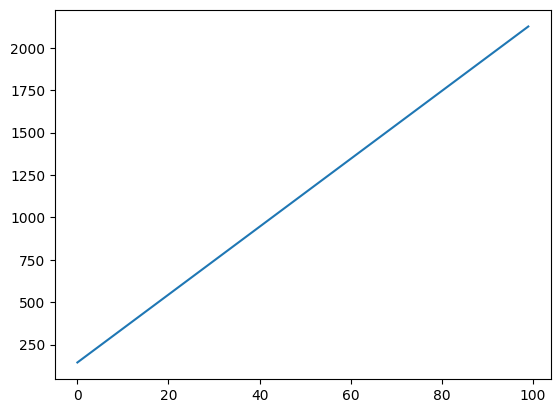

In [98]:
from simple_pid import PID
pid = PID(4, 0.1, 0.05, setpoint=120)

# Assume we have a system we want to control in controlled_system
#v = controlled_system.update(0)
diff_line = 125
x_pid = np.arange(0,100)
y_pid = []
for x in range(100):
    # Compute new output from the PID according to the systems current value
    control = pid(diff_line)
    print(control)
    # Feed the PID output to the system and get its current value
    #v = controlled_system.update(control)
    diff_line = diff_line - control
    y_pid.append(diff_line)
print(y_pid)
plt.plot(x_pid,y_pid)
